# CycleGAN

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)


cuda:0


In [2]:
!pip install kaggle

In [3]:
#Downloading dataset from kaggle
import json
import zipfile
kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}
print(kaggle_apikey) 

base_dir = '/home/azureuser/'
kaggle_dir = base_dir + '.kaggle'
print("base_dir:", base_dir[0])
print("kaggle_dir:", kaggle_dir)
if not os.path.exists(kaggle_dir): os.mkdir(kaggle_dir)

with open(kaggle_dir+'/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

# ! chmod 600 ~/.kaggle/kaggle.json
! chmod 600 {kaggle_dir}/kaggle.json

{'username': 'jamesdavey', 'key': 'a8975caa44cfa08d6f2164f2d5977b6e'}
base_dir: /
kaggle_dir: /home/azureuser/.kaggle


In [4]:
# open file at ~/.kaggle/kaggle.json and print it
with open(kaggle_dir+'/kaggle.json', 'r') as f:
    print(f.read())

{"username": "jamesdavey", "key": "a8975caa44cfa08d6f2164f2d5977b6e"}


number of images: 9877 ['1.png', '10.png', '100.png', '1000.png', '1001.png']


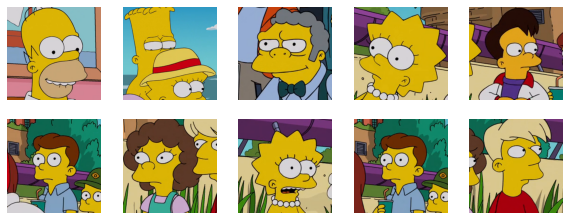

In [5]:
# ! kaggle datasets download -d kostastokis/simpsons-faces
# #unzip file simpsons-faces.zip
# with zipfile.ZipFile("simpsons-faces.zip","r") as zip_ref:
#     zip_ref.extractall("simpsons-data")

import os
file_paths = sorted(os.listdir('simpsons-data/cropped'))
print("number of images:", len(file_paths), file_paths[:5])
# display 10 images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread('simpsons-data/cropped/'+file_paths[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [7]:
! kaggle datasets download -d atulanandjha/lfwpeople
with zipfile.ZipFile("lfwpeople.zip","r") as zip_ref:
    zip_ref.extractall("face-data")

os.mkdir('face-data/faces')
print(os.listdir('face-data'))

 97%|██████████████████████████████████████▊ | 225M/232M [00:10<00:00, 37.6MB/s]
100%|████████████████████████████████████████| 232M/232M [00:13<00:00, 17.9MB/s]


In [125]:
!ls face-data
# import shutil
# shutil.rmtree('face-data/faces')

faces  lfw-funneled.tgz  pairs.txt  pairsDevTest.txt  pairsDevTrain.txt


In [126]:
import tarfile
tar = tarfile.open("face-data/lfw-funneled.tgz")
tar.extractall()
tar.close()

In [135]:
name_folders = sorted(os.listdir('lfw_funneled/')) # folders each containing images of one person
print("number of images:", len(file_paths), file_paths[:5])

number of images: 5760 ['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson']


NotADirectoryError: [Errno 20] Not a directory: 'lfw_funneled/pairs.txt'

In [136]:
!ls lfw_funneled/Abdullah_Gul

In [137]:
import glob
#get all files in lfw_funneled folder
all_files = glob.glob('lfw_funneled/*/*.jpg')
len(all_files)

In [ ]:
name_folders = sorted(os.listdir('lfw_funneled/Abdullah_Gul')) # folders each containing images of one person
name_folders

number of images: 5760 ['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson']


FileNotFoundError: [Errno 2] No such file or directory: 'face-data/faces/AJ_Cook'

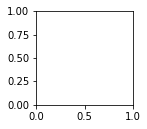

In [130]:


# display 10 images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread(file_paths[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
#Create traindataloader from simpsons dataset
class SimpsonsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = sorted(os.listdir(root_dir))
        self.len = len(self.file_paths)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        img = plt.imread(self.root_dir + self.file_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img
    
simposons_dataset = SimpsonsDataset('simpsons-data/cropped/', transform=transforms.ToTensor())


In [ ]:
# create a traindata loader for face-data/lfw-funneled
class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = sorted(os.listdir(root_dir))
        self.len = len(self.file_paths)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        img = plt.imread(self.root_dir + self.file_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img

In [ ]:
# Information:
# X is a dataset of human faces
# Y is a dataset of simpsons faces

# G: X -> Y, F: Y -> X

# G = UNet().to(device)
# F = UNet().to(device)

# D_y = Discriminator().to(device)
# D_x = Discriminator().to(device)

# D: Y -> [0,1], D': X -> [0,1]


In [18]:
class Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    def __init__(self, 
                input_channels: int = 3):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.leaky_relu(self.bn4(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        x = self.flatten(x)
        return torch.mean(x, dim=1)

input = torch.randn(5, 3, 256, 256)
D = Discriminator()
D(input).shape


torch.Size([5])

In [ ]:
###############################################################################
# Models
###############################################################################
num_classes = 14

class DoubleConv(nn.Module):
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
      
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    conv1 = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=0)
    conv2 = nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=0)

    nn.init.normal_(conv1.weight, mean=0.0, std= (2/(9*input_channels))**(1/2)) #sqrt(2/N)
    nn.init.normal_(conv2.weight, mean=0.0, std= (2/(9*output_channels))**(1/2)) 
    
    self.conv = nn.Sequential(conv1, nn.BatchNorm2d(output_channels), nn.ReLU(),
                              conv2, nn.BatchNorm2d(output_channels), nn.ReLU())
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.conv(x)

class DownSampleBlock(nn.Module):
  """
  DownSampling block in UNET

  MaxPool, DoubleCov
  MaxPool, Conv, BatchNorm, ReLU, Conv, BatchNorm, ReLU
  """
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.

    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.conv = DoubleConv(input_channels, output_channels)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.conv(self.max_pool(x))

class UpSampleBlock(nn.Module):
  """
  UpSampling block in UNET

  Upsample, Conv, Concat, Conv, ReLU, Conv, ReLU
  """
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.up_sample = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2)
    self.conv = DoubleConv(input_channels, output_channels)

  def forward(self, x: torch.Tensor, res: torch.Tensor) -> torch.Tensor:
    """Forward pass for DownSampleBlock.

     Parameters:
      x (torch.Tensor) -- input tensor to block
      res (torch.Tensor) -- residual connection feeding into block
    
    Return x
    x will be used as the input to the next upsizing block (or final layer)
    """
    x = self.up_sample(x)
    size_diff1 = (res.shape[2]-x.shape[2])//2
    size_diff2 = (res.shape[2]-x.shape[2]) - size_diff1
    x = torch.concat((x, res[:, :, size_diff1:-size_diff2, size_diff1:-size_diff2]), dim = 1)
    x = self.conv(x)
    return x

class UNET(nn.Module):
  def __init__(self, channels_in = 3):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      channels_in (int) -- input images channel size
    """
    super().__init__()
    self.first_conv = DoubleConv(channels_in, 64)
    self.downsample_blocks = nn.ModuleList([DownSampleBlock(c, 2*c) for c in [64, 128, 256, 512]])
    self.upsample_blocks = nn.ModuleList([UpSampleBlock(2*c, c) for c in [512, 256, 128, 64]])
    self.final_layer = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
    self.loss_fn = nn.CrossEntropyLoss()
  
  def forward(self, x: torch.Tensor, target=None) -> torch.Tensor:
    """Forward pass for DownSampleBlock.

     Parameters:
      x (torch.Tensor) --input tensor to block
      targets (torch.Tensor) --target output of model

    Returns (logits, loss)

    logits (torch.Tensor) --model's raw output
    loss (torch.float32) --2d CrossEntropyLoss result
    """
    x = self.first_conv(x)
    residuals = []
    for downsample in self.downsample_blocks:
      residuals.append(x)
      x = downsample(x)
    for i, upsample in enumerate(self.upsample_blocks):
      print(i, x.shape, residuals[-(i+1)].shape)
      x = upsample(x, residuals[-(i+1)])
    x = self.final_layer(x)

    if target is None:
      loss = None
    else:
      diff = 94 # (512 - 324)//2
      loss = self.loss_fn(x, target[:, 0, diff:-diff, diff:-diff])
    return x, loss

## Model architecture

In [ ]:
# Able to train on up-paired training data
#Translate an image from target to source domain

#Generator G horses -> zebras
#adversarial loss

#Inverse mapping F, zebras -> horses
#cycle consitency loss

In [ ]:
# X is a set of horses
# Y is a set of zebras

# G: X -> Y
# F: Y -> X

# Adversarial Loss:
#Discriminator D_Y classifies if an generated zebra is real or fake
#Discriminator D_X classifies if an generated horse is real or fake

# Forward Cycle Consistency Loss:
# X_hat = F(G(X))
# want to minimize ||X - X_hat|| (L1 loss)

# Backward Cycle Consistency Loss:
# Y_hat = G(F(Y))
# want to minimize ||Y - Y_hat|| (L1 loss)

In [ ]:
# Adversarial Loss:
#Loss_D(G, D_Y, X, Y) = -E[log(D_Y(Y))] - E[log(1 - D_Y(G(X)))]

#Cycle Consistency Loss:
#Loss_cyc(G, F, X, Y) = E||X - F(G(X))|| + E||Y - G(F(Y))|| (L1 Loss)

# Full Objective:
#Loss(G, F, D_X, D_Y, X, Y) = Loss_D(G, D_Y, X, Y) + Loss_D(F, D_X, Y, X) + lambda * Loss_cyc(G, F, X, Y)

In [ ]:
# Network Architecture:

# Discriminator: netowkr classifies if 70x70 patch is real or fake
# generating a grid

# Train G to minimize
# (D(G(x)) - 1)^2
# Train D to minimize
# (D(y)-1)^2 + D(G(x))^2

#batch size = 1
# lambda = 10
# lr = 0.0002 with Adam optimizer
#keep learning rate constant for 100 epochs,
#then linearly decay to 0 over next 100 epochs

In [ ]:
# import dataset of human faces


In [ ]:
G = UNET()
x = torch.randn((1, 4, 256, 256))
G(x)[0].shape

In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip3 install -q torchinfo
    from torchinfo import summary
summary(G, input_size=[1, 4, 512, 512], col_names =['input_size', 'output_size', 'num_params', 'trainable'])

In [ ]:
model = UNET().to(device)
image, target = sample["image"].to(device), sample["mask"].to(device)
logits, loss = model(image, target)
print(logits.shape, loss)

In [ ]:
## To Do:
# - Modify UNET to preseve image size